In [1]:
import os
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import fastparquet as fp
import os

/home/zjiay/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/zjiay/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:

base_dir = '/datasets/AddBiomechanics/raw_data/'
output_dir='/datasets/AddBiomechanics/processed_data/'
# Loop through each dataset in the base directory
dataset_count=0
for dataset in os.listdir(base_dir):

  dataset_count+=1
  if dataset_count>0:
    print(dataset_count,dataset)

1 Carter2023_Formatted_No_Arm
2 vanderZee2022_Formatted_No_Arm
3 Carter_participants_info.csv
4 Tiziana2019_Formatted_No_Arm
5 Camargo2021_Formatted_No_Arm
6 Tan2022_Formatted_No_Arm
7 Wang2023_Formatted_No_Arm
8 Han2023_Formatted_No_Arm
9 Hamner2013_Formatted_No_Arm
10 Moore2015_Formatted_No_Arm
11 Fregly2012_Formatted_No_Arm
12 Falisse2017_Formatted_No_Arm
13 Santos2017_Formatted_No_Arm


In [10]:
import os
import pandas as pd
import fastparquet
import pyarrow.parquet as pq
import numpy as np

# Define paths
parquet_file = os.path.join(output_dir, 'Carter2023_time.parquet')
csv_file = os.path.join(output_dir, "Participant_Info.csv")

# Load Participant_Info CSV using pandas
Participant_Info = pd.read_csv(csv_file)

# Function to process each chunk (row group)
def process_chunk(chunk, participant_info):
    # Clean 'subject' and 'task' columns
    chunk['subject'] = chunk['subject'].str.replace(r'(_.*)$', '', regex=True)
    chunk['task'] = chunk['task'].str.replace(r'_..$', '', regex=True)

    # Split 'task' column into three parts
    chunk[['task_part1', 'task_part2', 'task_part3']] = chunk['task'].str.split('_', expand=True, n=2)

    # Create 'incline' column
    chunk['incline'] = 0.01  # Default to 0.01
    chunk.loc[chunk['task_part1'].str.contains('uphill', case=False), 'incline'] = 0.06
    chunk.loc[chunk['task_part1'].str.contains('downhill', case=False), 'incline'] = -0.04

    # Create 'activity_type' column
    chunk['activity_type'] = 'other'
    chunk.loc[chunk['task_part1'].str.contains('walk', case=False), 'activity_type'] = 'walk'
    chunk.loc[chunk['task_part1'].str.contains('run', case=False), 'activity_type'] = 'run'

    # Merge with Participant_Info using pandas
    chunk = chunk.merge(participant_info[['Participant_code', 'Norm_Speed (km/h)']],
                        left_on='subject', right_on='Participant_code', how='left')

    # Apply the velocity logic
    conditions = [
        (chunk['activity_type'] == 'walk') & (chunk['task_part2'].str.contains('slow', case=False)),
        (chunk['activity_type'] == 'walk') & (chunk['task_part2'].str.contains('fast', case=False)),
        (chunk['activity_type'] == 'run') & (chunk['task_part2'].str.contains('fixed', case=False)),
        (chunk['activity_type'] == 'run') & (chunk['task_part2'].str.contains('slow', case=False)),
        (chunk['activity_type'] == 'run') & (chunk['task_part2'].str.contains('fast', case=False)),
        (chunk['activity_type'] == 'run') & (chunk['task_part2'].str.contains('norm', case=False)),
    ]

    choices = [
        3,  # slow walk
        5,  # fast walk
        12,  # fixed running speed
        chunk['Norm_Speed (km/h)'] * 0.9,  # slow run
        chunk['Norm_Speed (km/h)'] * 1.1,  # fast run
        chunk['Norm_Speed (km/h)'],  # normal run
    ]

    chunk['walking_speed'] = np.select(conditions, choices, default=None)

    # Create 'trial' column
    chunk['trial'] = chunk['task_part3']

    # Drop the original split columns
    chunk.drop(columns=['task_part1', 'task_part2', 'task_part3'], inplace=True)

    return chunk

# Function to process and save data in row-group chunks
def process_in_row_group_chunks(parquet_file, participant_info, output_file):
    parquet_data = fastparquet.ParquetFile(parquet_file)  # Load parquet file
    first_chunk = True

    # Iterate over row groups in the Parquet file
    for row_group in range(parquet_data.num_row_groups):
        # Read a row group of the data
        chunk = parquet_data.to_pandas(row_group=row_group)

        # Process the current chunk
        processed_chunk = process_chunk(chunk, participant_info)

        # Save the processed chunk to Parquet (append mode for subsequent chunks)
        processed_chunk.to_parquet(output_file, index=False, mode='a', engine='pyarrow', append=not first_chunk)

        # Ensure first_chunk is False after the first write
        first_chunk = False

# Call the function to process in row group chunks
output_file = os.path.join(output_dir, 'Carter_added.parquet')
process_in_row_group_chunks(parquet_file, Participant_Info, output_file)

print("Processing and saving completed.")


FileNotFoundError: [Errno 2] No such file or directory: '/datasets/AddBiomechanics/processed_data/Participant_Info.csv'

In [ ]:
df = pd.read_parquet(os.path.join(output_dir, 'Carter2023_time.parquet'),engine='pyarrow')
column_names = df.columns.tolist()
df['subject'] = df['subject'].str.replace(r'(_.*)$', '', regex=True)
df['task'] = df['task'].str.replace(r'_..$', '', regex=True)
print(df['subject'].unique())

Participant_Info= pd.read_csv(os.path.join(output_dir, "Participant_Info.csv"))



# Split 'task' column into three parts and create new columns
df[['task_part1', 'task_part2', 'task_part3']] = pd.DataFrame(
    df['task'].apply(lambda task: task.split('_') + [None]*(3-len(task.split('_')))).tolist(),
    index=df.index
)

# Create 'incline' column: Apply a more memory-efficient lambda function directly
df['incline'] = pd.Series(0.01, index=df.index)  # Default to 0.01
df.loc[df['task_part1'].str.contains('uphill', case=False), 'incline'] = 0.06
df.loc[df['task_part1'].str.contains('downhill', case=False), 'incline'] = -0.04

# Create 'activity_type' column: Optimize by using `np.where`
df['activity_type'] = pd.Series('other', index=df.index)
df.loc[df['task_part1'].str.contains('walk', case=False), 'activity_type'] = 'walk'
df.loc[df['task_part1'].str.contains('run', case=False), 'activity_type'] = 'run'

# Merge the DataFrames on 'subject' and 'Participant_code'
df = df.merge(Participant_Info[['Participant_code', 'Norm_Speed (km/h)']],
              left_on='subject', right_on='Participant_code', how='left')

# Apply the velocity logic more efficiently using `np.select`
import numpy as np

conditions = [
    (df['activity_type'] == 'walk') & (df['task_part2'].str.contains('slow', case=False)),
    (df['activity_type'] == 'walk') & (df['task_part2'].str.contains('fast', case=False)),
    (df['activity_type'] == 'run') & (df['task_part2'].str.contains('fixed', case=False)),
    (df['activity_type'] == 'run') & (df['task_part2'].str.contains('slow', case=False)),
    (df['activity_type'] == 'run') & (df['task_part2'].str.contains('fast', case=False)),
    (df['activity_type'] == 'run') & (df['task_part2'].str.contains('norm', case=False)),
]

choices = [
    3,  # slow walk
    5,  # fast walk
    12,  # fixed running speed
    df['Norm_Speed (km/h)'] * 0.9,  # slow run
    df['Norm_Speed (km/h)'] * 1.1,  # fast run
    df['Norm_Speed (km/h)'],  # normal run
]

df['walking_speed'] = np.select(conditions, choices, default=None)

# Create 'trial' column to store the value of 'task_part3'
df['trial'] = df['task_part3']

# Drop the original split columns to save memory
df.drop(columns=['task_part1', 'task_part2', 'task_part3'], inplace=True)

# Save the updated DataFrame back to a parquet file (optional)
df.to_parquet('Carter_added.parquet', index=False)

# Display the first few rows to verify
print(df.head())


In [ ]:
df

In [ ]:
print(df['task'].unique())

['uphillrun_norm_1' 'uphillrun_slow_1' 'Static_1' 'walk_fast_1'
 'walk_slow_1' 'flatrun_fast_1' 'flatrun_norm_1' 'flatrun_fixed_1'
 'flatrun_slow_1']


In [ ]:
print(df.columns)

Index(['subject', 'task', 'time_step', 'accum_time', 'contact_r', 'contact_l',
       'GRF_x_r', 'GRF_y_r', 'GRF_z_r', 'GRF_x_l', 'GRF_y_l', 'GRF_z_l',
       'COP_x_r', 'COP_y_r', 'COP_z_r', 'COP_x_l', 'COP_y_l', 'COP_z_l',
       'pelvis_angle_s', 'pelvis_angle_f', 'pelvis_angle_t', 'hip_angle_s_r',
       'hip_angle_f_r', 'hip_angle_t_r', 'knee_angle_s_r', 'ankle_angle_s_r',
       'ankle_angle_t_r', 'hip_angle_s_l', 'hip_angle_f_l', 'hip_angle_t_l',
       'knee_angle_s_l', 'ankle_angle_s_l', 'ankle_angle_t_l', 'dorsi_angle_r',
       'dorsi_angle_l', 'shank_angle_r', 'shank_angle_l', 'thigh_angle_r',
       'thigh_angle_l', 'shank_vel_r', 'shank_vel_l', 'thigh_vel_r',
       'thigh_vel_l', 'ankle_vel_r', 'ankle_vel_l', 'pelvis_vel_s',
       'pelvis_vel_f', 'pelvis_vel_t', 'hip_vel_s_r', 'hip_vel_f_r',
       'hip_vel_t_r', 'knee_vel_s_r', 'ankle_vel_s_r', 'ankle_vel_t_r',
       'hip_vel_s_l', 'hip_vel_f_l', 'hip_vel_t_l', 'knee_vel_s_l',
       'ankle_vel_s_l', 'ankle_vel_t_l', 

In [ ]:
df['GRF_y_r>50_r'] = (df['GRF_y_r'] > 20).astype(int)
# Ensure the diff and comparison are applied correctly
df['heel_strike_r'] = df['contact_r'].diff().fillna(0).gt(0).astype(int)

# Display the first few rows to verify the new column
# Calculate the average of the absolute differences between two columns
average_absolute_difference = (df['GRF_y_r>50_r'] - df['contact_r']).abs().mean()

# Print the result
print(average_absolute_difference)



# Display the first few rows to show the new column
df.head()

0.0


,subject,task,time_step,accum_time,contact_r,contact_l,GRF_x_r,GRF_y_r,GRF_z_r,GRF_x_l,...,knee_tau_s_l,ankle_tau_s_l,incline,activity_type,Participant_code,Norm_Speed (km/h),velocity,trial,GRF_y_r>50_r,heel_strike_r
0,P051,uphillrun_norm_1,0,0.000000,0,0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.06,run,P051,10.4,10.4,1,0,0
1,P051,uphillrun_norm_1,1,0.004000,0,0,0.0,0.0,0.0,0.0,...,-152.674036,6.981588,0.06,run,P051,10.4,10.4,1,0,0
2,P051,uphillrun_norm_1,2,0.008000,0,0,0.0,0.0,0.0,0.0,...,-70.674749,4.004911,0.06,run,P051,10.4,10.4,1,0,0
3,P051,uphillrun_norm_1,3,0.012000,0,0,0.0,0.0,0.0,0.0,...,3.454256,1.088232,0.06,run,P051,10.4,10.4,1,0,0
4,P051,uphillrun_norm_1,4,0.015999,0,0,0.0,0.0,0.0,0.0,...,49.230367,-0.965316,0.06,run,P051,10.4,10.4,1,0,0


In [ ]:
filtered_df = df[(df['task'] == 'flatrun_norm_1') & (df['subject'] == 'P023')]

# Print the unique subjects in the filtered DataFrame
print(filtered_df['subject'].unique())


['P023']


In [ ]:
# Check the lengths of each list in the dictionary
for key, value in user_info.items():
    print(f"{key}: {len(value)}")


In [ ]:
df


In [ ]:
# Filter for the tasks that have 'level' in the name
df_level_groun = df[df['task'].str.contains('level')]

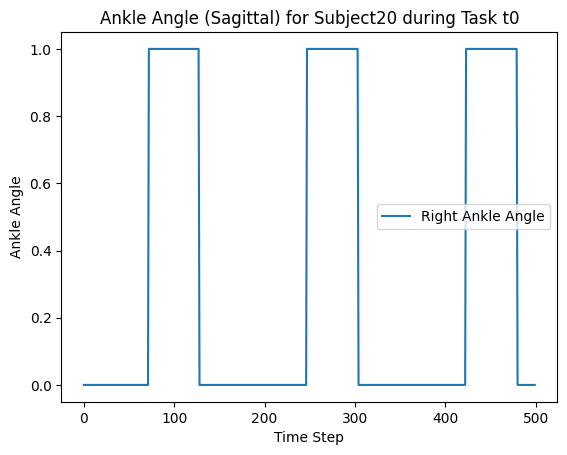

In [ ]:
ankle_local=filtered_df['contact_r'].to_numpy( )
time_steps = filtered_df['time_step'].to_numpy()
plt.plot( ankle_local[1000:1500], label='Right Ankle Angle')
#plt.plot(time_steps, dorsi_angle_l, label='Left Ankle Angle')
plt.xlabel('Time Step')
plt.ylabel('Ankle Angle')
plt.title('Ankle Angle (Sagittal) for Subject20 during Task t0')
plt.legend()
plt.grid(False)
plt.show()

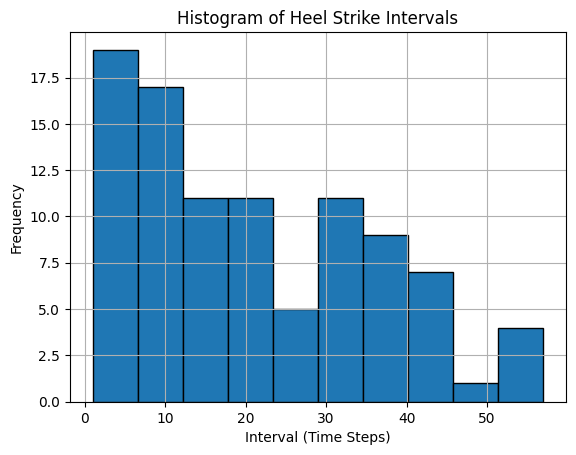

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure the DataFrame is sorted by time_step
filtered_df = filtered_df.sort_values(by='time_step')

# Extract heel strike data and time steps
ankle_local = filtered_df['heel_strike_r'].to_numpy()
time_steps = filtered_df['time_step'].to_numpy()

# Get the indices where heel strikes occur (heel_strike_r == 1)
heel_strike_indices = np.where(ankle_local == 1)[0]

# Compute the intervals between consecutive heel strikes
heel_strike_intervals = np.diff(time_steps[heel_strike_indices])

# Keep only positive intervals
heel_strike_intervals = heel_strike_intervals[heel_strike_intervals > 0]

# Plot a histogram of the positive intervals
plt.hist(heel_strike_intervals, bins=10, edgecolor='black')
plt.xlabel('Interval (Time Steps)')
plt.ylabel('Frequency')
plt.title('Histogram of Heel Strike Intervals')
plt.grid(True)
plt.show()

